<a href="https://colab.research.google.com/github/Mohamed-01-git/MODELIZATION/blob/main/SEASONAL_FORCAST_93_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !pip install virtualenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 22.1 MB/s eta 0:00:00


In [ ]:
#!virtualenv "/content/drive/MyDrive/MODELIZATION/MODELISATION"

created virtual environment CPython3.10.12.final.0-64 in 25489ms
  creator CPython3Posix(dest=/content/drive/MyDrive/MODELIZATION/MODELISATION, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/root/.local/share/virtualenv)
    added seed packages: pip==24.2, setuptools==75.2.0, wheel==0.44.0
  activators BashActivator,CShellActivator,FishActivator,NushellActivator,PowerShellActivator,PythonActivator


In [2]:
!source "/content/drive/MyDrive/MODELIZATION/MODELISATION/bin/activate"
!pip install numpy pandas xarray xskillscore
!pip install cdsapi
!pip install matplotlib cartopy
!pip install cfgrib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for multiurl: filename=multiurl-0.3.2-py3-none-any.whl size=21238 sha256=af3a4579a86e193887639fa606e5ea7643c9b332257f23544e66dc7f2736f6e2
  Stored in directory: /root/.cache/pip/wheels/6a/a4/4d/4290aa85d06f3885093ca0f50fcda5ecc9198c9dad84c8cb65
Successfully built multiurl
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.7/48.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.7 MB/s eta 0:00:00
  Created wheel for findlibs: filename=findlibs-0.0.5-py3-none-any.whl size=6944 sha256=a4734156a3905a7f1653574de67c79dc4668b5802ec5597ccbeffd58fe5373a0
  Stored in directory: /root/.cache/pip/wheels/2e/67/14/22fa5b9fd9c41be520b37e908597

# **1.LOAD THE REQUIRED LIBRARIES**

In [3]:
# CDS API
import cdsapi

# Libraries for working with multi-dimensional arrays
import xarray as xr
import pandas as pd
import numpy as np

# Forecast verification metrics with xarray
import xskillscore as xs

# Date and calendar libraries
from dateutil.relativedelta import relativedelta
import calendar

# Libraries for plotting and geospatial data visualisation
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Disable warnings for data download via API and matplotlib (do I need both???)
import warnings
warnings.filterwarnings('ignore')

# **2.READ THE DATA**

In [26]:
DATADIR ="/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA"
config = dict(
    list_vars = ['2m_temperature', ],
    hcstarty = 1993,
    hcendy = 2016,
    start_month = 11,
)

In [5]:
import os

SCOREDIR = DATADIR + '/scores'
PLOTSDIR = DATADIR + f'/plots/stmonth{config["start_month"]:02d}'

for directory in [DATADIR, SCOREDIR, PLOTSDIR]:
    # Check if the directory exists
    if not os.path.exists(directory):
        # If it doesn't exist, create it
        os.makedirs(directory)
        print(f'Creating folder {directory}')

In [6]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". This is the default option in this notebook
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see CDS documentation about nominal start date)
st_dim_name = 'time' if not config.get('isLagged',False) else 'indexing_time'

In [ ]:
print('Reading HCST data from file')
hcst_fname="/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA/ecmwf_51_1993-2016_monthly_mean_11_234_45:-30:-2.5:60.grib"
hcst = xr.open_dataset(hcst_fname,engine='cfgrib', backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name),filter_by_keys={'paramId':167}))
hcst = hcst.chunk({'forecastMonth':1, 'latitude':'auto', 'longitude':'auto'})  #force dask.array using chunks on leadtime, latitude and longitude coordinate
hcst = hcst.rename({'latitude':'lat','longitude':'lon', st_dim_name:'start_date'})

Reading HCST data from file


# **2.a : ANOMALIE**

In [ ]:
hcst

<xarray.Dataset> Size: 31MB
Dimensions:        (number: 25, forecastMonth: 3, start_date: 24, lat: 48,
                    lon: 91)
Coordinates:
  * number         (number) int64 200B 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 24B 2 3 4
  * start_date     (start_date) datetime64[ns] 192B 1993-11-01 ... 2016-11-01
    surface        float64 8B ...
  * lat            (lat) float64 384B 44.5 43.5 42.5 41.5 ... 0.5 -0.5 -1.5 -2.5
  * lon            (lon) float64 728B -30.0 -29.0 -28.0 -27.0 ... 58.0 59.0 60.0
    start_month    int64 8B 11
    valid_time     (start_date, forecastMonth) datetime64[ns] 576B 1993-12-01...
Data variables:
    t2m            (number, forecastMonth, start_date, lat, lon) float32 31MB dask.array<chunksize=(25, 1, 24, 48, 91), meta=np.ndarray>
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-23T21:19 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
print ('Re-arranging time metadata in xr.Dataset object')
# Add start_month to the xr.Dataset
start_month = pd.to_datetime(hcst.start_date.values[0]).month
hcst = hcst.assign_coords({'start_month':start_month})
# Add valid_time to the xr.Dataset
vt = xr.DataArray(dims=('start_date','forecastMonth'), coords={'forecastMonth':hcst.forecastMonth,'start_date':hcst.start_date})
vt.data = [[pd.to_datetime(std)+relativedelta(months=fcmonth-1) for fcmonth in vt.forecastMonth.values] for std in vt.start_date.values]
hcst = hcst.assign_coords(valid_time=vt)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period, so the first N-1 elements have NaN and can be dropped
print('Computing 3-month aggregation')
hcst_3m = hcst.rolling(forecastMonth=3).mean()
hcst_3m = hcst_3m.where(hcst_3m.forecastMonth>=3,drop=True)


# CALCULATE ANOMALIES (and save to file)
print('Computing anomalies 1m')
hcmean = hcst.mean(['number','start_date'])
anom = hcst - hcmean
anom = anom.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

print('Computing anomalies 3m')
hcmean_3m = hcst_3m.mean(['number','start_date'])
anom_3m = hcst_3m - hcmean_3m
anom_3m = anom_3m.assign_attrs(reference_period='{hcstarty}-{hcendy}'.format(**config))

print('Saving anomalies 1m/3m to netCDF files')
hcst_bname="ecmwf_51_1993-2016_monthly_mean"
anom.to_netcdf(f'{DATADIR}/{hcst_bname}.1m.anom.nc')
anom_3m.to_netcdf(f'{DATADIR}/{hcst_bname}.3m.anom.nc')

Re-arranging time metadata in xr.Dataset object
Computing 3-month aggregation
Computing anomalies 1m
Computing anomalies 3m
Saving anomalies 1m/3m to netCDF files


# **2.b : PROBABILITIES FOR TERCILE CATEGORIES**

In [ ]:
# We define a function to calculate the boundaries of forecast categories defined by quantiles
def get_thresh(icat,quantiles,xrds,dims=['number','start_date']):

    if not all(elem in xrds.dims for elem in dims):
        raise Exception('Some of the dimensions in {} is not present in the xr.Dataset {}'.format(dims,xrds))
    else:
        if icat == 0:
            xrds_lo = -np.inf
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)

        elif icat == len(quantiles):
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = np.inf

        else:
            xrds_lo = xrds.quantile(quantiles[icat-1],dim=dims)
            xrds_hi = xrds.quantile(quantiles[icat],dim=dims)

    return xrds_lo,xrds_hi

In [ ]:
#  CALCULATE PROBABILITIES for tercile categories by counting members within each category

print('Computing probabilities (tercile categories)')
quantiles = [1/3., 2/3.]
numcategories = len(quantiles)+1

for aggr,h in [("1m",hcst), ("3m",hcst_3m)]:
    print(f'Computing tercile probabilities {aggr}')

    l_probs_hcst=list()
    for icat in range(numcategories):
        print(f'category={icat}')
        h_lo,h_hi = get_thresh(icat, quantiles, h)
        probh = np.logical_and(h>h_lo, h<=h_hi).sum('number')/float(h.dims['number'])
        # Instead of using the coordinate 'quantile' coming from the hindcast xr.Dataset
        # we will create a new coordinate called 'category'
        if 'quantile' in probh:
            probh = probh.drop('quantile')
        l_probs_hcst.append(probh.assign_coords({'category':icat}))

    print(f'Concatenating {aggr} tercile probs categories')
    probs = xr.concat(l_probs_hcst,dim='category')
    print(f'Saving {aggr} tercile probs netCDF files')
    probs.to_netcdf(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

Computing probabilities (tercile categories)
Computing tercile probabilities 1m
category=0
category=1
category=2
Concatenating 1m tercile probs categories
Saving 1m tercile probs netCDF files
Computing tercile probabilities 3m
category=0
category=1
category=2
Concatenating 3m tercile probs categories
Saving 3m tercile probs netCDF files


# **3 : COMPUTE SCORES**

## *3.1 DETERMINISTIC SCORES*

### *3.1.1 Read the Observation Data*

in this case we'll juste read the temperature data, because the precipitation data doesn't have the same time variable

In [ ]:
# obs_fname="/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA/era5_monthly_stmonth01_1993-2016.grib"
obs_fname='/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA/era5_monthly_stmonth{"NOVEMBER"}_{1993}-{2016}.grib'
era5_1deg = xr.open_dataset(obs_fname, engine='cfgrib',backend_kwargs={'filter_by_keys':{'paramId':167}})

In [ ]:
era5_1deg.valid_time.values

array(['1993-01-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-03-01T00:00:00.000000000', '1993-04-01T00:00:00.000000000',
       '1993-05-01T00:00:00.000000000', '1993-06-01T00:00:00.000000000',
       '1993-07-01T00:00:00.000000000', '1993-08-01T00:00:00.000000000',
       '1993-09-01T00:00:00.000000000', '1993-10-01T00:00:00.000000000',
       '1993-11-01T00:00:00.000000000', '1993-12-01T00:00:00.000000000',
       '1994-01-01T00:00:00.000000000', '1994-02-01T00:00:00.000000000',
       '1994-03-01T00:00:00.000000000', '1994-04-01T00:00:00.000000000',
       '1994-05-01T00:00:00.000000000', '1994-06-01T00:00:00.000000000',
       '1994-07-01T00:00:00.000000000', '1994-08-01T00:00:00.000000000',
       '1994-09-01T00:00:00.000000000', '1994-10-01T00:00:00.000000000',
       '1994-11-01T00:00:00.000000000', '1994-12-01T00:00:00.000000000',
       '1995-01-01T00:00:00.000000000', '1995-02-01T00:00:00.000000000',
       '1995-03-01T00:00:00.000000000', '1995-04-01

In [ ]:
# Renaming to match hindcast names
era5_1deg = era5_1deg.rename({'latitude':'lat','longitude':'lon','time':'start_date'}).swap_dims({'start_date':'valid_time'})




# Assign 'forecastMonth' coordinate values
fcmonths = [mm+1 if mm>=0 else mm+13 for mm in [t.month - config['start_month'] for t in pd.to_datetime(era5_1deg.valid_time.values)] ]
era5_1deg = era5_1deg.assign_coords(forecastMonth=('valid_time',fcmonths))
# Drop obs values not needed (earlier than first start date) - this is useful to create well shaped 3-month aggregations from obs.
era5_1deg = era5_1deg.where(era5_1deg.valid_time>=np.datetime64('{hcstarty}-{start_month:02d}-01'.format(**config)),drop=True)

# CALCULATE 3-month AGGREGATIONS
# NOTE rolling() assigns the label to the end of the N month period
print('Calculate observation 3-monthly aggregations')
# NOTE care should be taken with the data available in the "obs" xr.Dataset so the rolling mean (over valid_time) is meaningful
era5_1deg_3m = era5_1deg.rolling(valid_time=3).mean()
era5_1deg_3m = era5_1deg_3m.where(era5_1deg_3m.forecastMonth>=3)

# As we don't need it anymore at this stage, we can safely remove
# 'forecastMonth'
era5_1deg = era5_1deg.drop('forecastMonth')
era5_1deg_3m = era5_1deg_3m.drop('forecastMonth')

Calculate observation 3-monthly aggregations


### *3.1.2 : Compute Deterministic Scores*

In [ ]:
from os.path import join

# Loop over aggregations
anom_name = "ecmwf_51_1993-2016_monthly_mean"
for aggr in ['1m', '3m']:

    if aggr == '1m':
        o = era5_1deg
    elif aggr == '3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    print(f'Computing deterministic scores for {aggr}-aggregation')

    # Read anomalies file
    h = xr.open_dataset(f'{DATADIR}/{hcst_bname}.{aggr}.anom.nc')
    is_fullensemble = 'number' in h.dims

    l_corr = list()
    l_corr_pval = list()

    for this_fcmonth in h.forecastMonth.values:
        print(f'forecastMonth={this_fcmonth}')
        thishcst = h.sel(forecastMonth=this_fcmonth).swap_dims({'start_date': 'valid_time'})
        thisobs = o.where(o.valid_time == thishcst.valid_time, drop=True)

        # Align the forecast and observation data along all common dimensions
        thishcst_em, thisobs_aligned = xr.align(thishcst, thisobs, join='inner')

        # If it's a full ensemble, take the mean over the 'number' dimension
        thishcst_em = thishcst_em if not is_fullensemble else thishcst_em.mean('number')

        l_corr.append(xs.spearman_r(thishcst_em, thisobs_aligned, dim='valid_time'))
        l_corr_pval.append(xs.spearman_r_p_value(thishcst_em, thisobs_aligned, dim='valid_time'))

    print(f'Concatenating (by fcmonth) correlation for {aggr}-aggregation')
    corr = xr.concat(l_corr, dim='forecastMonth')
    corr_pval = xr.concat(l_corr_pval, dim='forecastMonth')

    print(f'Saving to netCDF file correlation for {aggr}-aggregation')
    corr.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr.nc')
    corr_pval.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr_pval.nc')

Computing deterministic scores for 1m-aggregation
forecastMonth=2
forecastMonth=3
forecastMonth=4
Concatenating (by fcmonth) correlation for 1m-aggregation
Saving to netCDF file correlation for 1m-aggregation
Computing deterministic scores for 3m-aggregation
forecastMonth=3
forecastMonth=4
Concatenating (by fcmonth) correlation for 3m-aggregation
Saving to netCDF file correlation for 3m-aggregation


### *3.1.2 : Compute probabilistic scores for tercile categories*

In [ ]:
# Loop over aggregations
for aggr in ['1m','3m']:

    if aggr=='1m':
        o = era5_1deg
    elif aggr=='3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    print(f'Computing deterministic scores for {aggr}-aggregation')

    # READ hindcast probabilities file
    probs_hcst = xr.open_dataset(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

    l_roc=list()
    l_rps=list()
    l_rocss=list()
    l_bs=list()
    for this_fcmonth in probs_hcst.forecastMonth.values:
        print(f'forecastMonth={this_fcmonth}')
        thishcst = probs_hcst.sel(forecastMonth=this_fcmonth).swap_dims({'start_date':'valid_time'})

        # CALCULATE probabilities from observations
        print('We need to calculate probabilities (tercile categories) from observations')
        l_probs_obs=list()
        thiso = o.where(o.valid_time==thishcst.valid_time,drop=True)
        for icat in range(numcategories):
            #print(f'category={icat}')
            o_lo,o_hi = get_thresh(icat, quantiles, thiso, dims=['valid_time'])
            probo = 1. * np.logical_and(thiso>o_lo, thiso<=o_hi)
            if 'quantile' in probo:
                probo=probo.drop('quantile')
            l_probs_obs.append(probo.assign_coords({'category':icat}))

        thisobs = xr.concat(l_probs_obs, dim='category')

        print('Now we can calculate the probabilistic (tercile categories) scores')
        thisroc = xr.Dataset()
        thisrps = xr.Dataset()
        thisrocss = xr.Dataset()
        thisbs = xr.Dataset()
        for var in thishcst.data_vars:
            thisroc[var] = xs.roc(thisobs[var],thishcst[var], dim='valid_time', bin_edges=np.linspace(0,1,101))

            thisrps[var] = xs.rps(thisobs[var],thishcst[var], dim='valid_time', category_edges=None, input_distributions='p')

            thisrocss[var] = (thisroc[var] - 0.5) / (1. - 0.5)
            bscat = list()
            for cat in thisobs[var].category:
                #print(f'compute BS ({var}) for cat={cat.values}' )
                thisobscat = thisobs[var].sel(category=cat)
                thishcstcat = thishcst[var].sel(category=cat)
                bscat.append(xs.brier_score(thisobscat, thishcstcat, dim='valid_time'))
            thisbs[var] = xr.concat(bscat,dim='category')

        l_roc.append(thisroc)
        l_rps.append(thisrps)
        l_rocss.append(thisrocss)
        l_bs.append(thisbs)


    print('concat roc')
    roc=xr.concat(l_roc,dim='forecastMonth')
    print('concat rps')
    rps=xr.concat(l_rps,dim='forecastMonth')
    print('concat rocss')
    rocss=xr.concat(l_rocss,dim='forecastMonth')
    print('concat bs')
    bs=xr.concat(l_bs,dim='forecastMonth')

    print('writing to netcdf rps')
    rps.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rps.nc')
    print('writing to netcdf bs')
    bs.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.bs.nc')
    print('writing to netcdf roc')
    roc.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.roc.nc')
    print('writing to netcdf rocss')
    rocss.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rocss.nc')

Computing deterministic scores for 1m-aggregation
forecastMonth=2
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
forecastMonth=3
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores


ValueError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'valid_time' ('valid_time',)

In [ ]:
from os.path import join

# Loop over aggregations
anom_name = "ecmwf_51_1993-2016_monthly_mean"
for aggr in ['1m', '3m']:

    if aggr == '1m':
        o = era5_1deg
    elif aggr == '3m':
        o = era5_1deg_3m
    else:
        raise BaseException(f'Unknown aggregation {aggr}')

    print(f'Computing deterministic scores for {aggr}-aggregation')

    # Read hindcast probabilities file
    probs_hcst = xr.open_dataset(f'{DATADIR}/{hcst_bname}.{aggr}.tercile_probs.nc')

    l_roc = list()
    l_rps = list()
    l_rocss = list()
    l_bs = list()

    for this_fcmonth in probs_hcst.forecastMonth.values:
        print(f'forecastMonth={this_fcmonth}')
        thishcst = probs_hcst.sel(forecastMonth=this_fcmonth).swap_dims({'start_date': 'valid_time'})

        # CALCULATE probabilities from observations
        print('We need to calculate probabilities (tercile categories) from observations')
        l_probs_obs = list()

        # Align both forecast and observation data on 'valid_time'
        thiso = o.where(o.valid_time == thishcst.valid_time, drop=True)
        thishcst_aligned, thiso_aligned = xr.align(thishcst, thiso, join='inner')

        for icat in range(numcategories):
            # Compute category thresholds and probabilities for observations
            o_lo, o_hi = get_thresh(icat, quantiles, thiso_aligned, dims=['valid_time'])
            probo = 1. * np.logical_and(thiso_aligned > o_lo, thiso_aligned <= o_hi)

            if 'quantile' in probo:
                probo = probo.drop('quantile')

            l_probs_obs.append(probo.assign_coords({'category': icat}))

        thisobs = xr.concat(l_probs_obs, dim='category')

        # Now we can calculate the probabilistic (tercile categories) scores
        print('Now we can calculate the probabilistic (tercile categories) scores')
        thisroc = xr.Dataset()
        thisrps = xr.Dataset()
        thisrocss = xr.Dataset()
        thisbs = xr.Dataset()

        for var in thishcst_aligned.data_vars:
            thisroc[var] = xs.roc(thisobs[var], thishcst_aligned[var], dim='valid_time', bin_edges=np.linspace(0,1,101))

            thisrps[var] = xs.rps(thisobs[var], thishcst_aligned[var], dim='valid_time', category_edges=None, input_distributions='p')

            thisrocss[var] = (thisroc[var] - 0.5) / (1. - 0.5)

            bscat = list()
            for cat in thisobs[var].category:
                print(f'compute BS ({var}) for cat={cat.values}' )
                thisobscat = thisobs[var].sel(category=cat)
                thishcstcat = thishcst_aligned[var].sel(category=cat)
                bscat.append(xs.brier_score(thisobscat, thishcstcat, dim='valid_time'))

            thisbs[var] = xr.concat(bscat, dim='category')

        l_roc.append(thisroc)
        l_rps.append(thisrps)
        l_rocss.append(thisrocss)
        l_bs.append(thisbs)

    print('concat roc')
    roc = xr.concat(l_roc, dim='forecastMonth')
    print('concat rps')
    rps = xr.concat(l_rps, dim='forecastMonth')
    print('concat rocss')
    rocss = xr.concat(l_rocss, dim='forecastMonth')
    print('concat bs')
    bs = xr.concat(l_bs, dim='forecastMonth')

    print('writing to netcdf rps')
    rps.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rps.nc')
    print('writing to netcdf bs')
    bs.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.bs.nc')
    print('writing to netcdf roc')
    roc.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.roc.nc')
    print('writing to netcdf rocss')
    rocss.to_netcdf(f'{DATADIR}/scores/{hcst_bname}.{aggr}.rocss.nc')


Computing deterministic scores for 1m-aggregation
forecastMonth=2
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
forecastMonth=3
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
forecastMonth=4
We need to calculate probabilities (tercile categories) from observations
Now we can calculate the probabilistic (tercile categories) scores
compute BS (t2m) for cat=0
compute BS (t2m) for cat=1
compute BS (t2m) for cat=2
concat roc
concat rps
concat rocss
concat bs
writing to netcdf rps
writing to netcdf bs
writing to netcdf roc
writing to netcdf rocss
Computing deterministic scores for 3m-aggregation
forecastMonth=3
We need to calculate probabilities (

## **4. Visualize verification plots**

In [21]:
# Subset of plots to be produced
aggr  = '1m'
fcmonth = 2

# Common labels to be used in plot titles
VARNAMES = {
    't2m' : '2-metre temperature',
#     'sst' : 'sea-surface temperature',
#     'msl' : 'mean-sea-level pressure',
#     'tp'  : 'total precipitation'
}


CATNAMES=['lower tercile', 'middle tercile', 'upper tercile']

# Change titles font size
plt.rc('axes', titlesize=20)

In [22]:
# PREPARE STRINGS for TITLES
origin_labels = {'institution': 'CMCC', 'name': 'SPSv3.5'}
tit_line1 = '{institution} {name}'.format(**origin_labels)
# tit_line2_base = rf'Start month: $\bf{calendar.month_abbr[config["start_month"]].upper()}$'
tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'

if aggr=='1m':
    validmonth = config['start_month'] + (fcmonth-1)
    validmonth = validmonth if validmonth<=12 else validmonth-12
#     tit_line2 = tit_line2_base + rf' - Valid month: $\bf{calendar.month_abbr[validmonth].upper()}$'
    tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
elif aggr=='3m':
    validmonths = [vm if vm<=12 else vm-12 for vm in [config['start_month'] + (fcmonth-1) - shift for shift in range(3)]]
    validmonths = [calendar.month_abbr[vm][0] for vm in reversed(validmonths)]
#     tit_line2 = tit_line2_base + rf' - Valid months: $\bf{"".join(validmonths)}$'
    tit_line2 = tit_line2_base + f' - Valid months: {"".join(validmonths)}'
else:
    raise BaseException(f'Unexpected aggregation {aggr}')

In [23]:
fcmonth

2

Data values matrices need to be transposed


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA/plots/stmonth01/ecmwf_51_1993-2016_monthly_mean.1m.fcmonth2.t2m.corr.png'

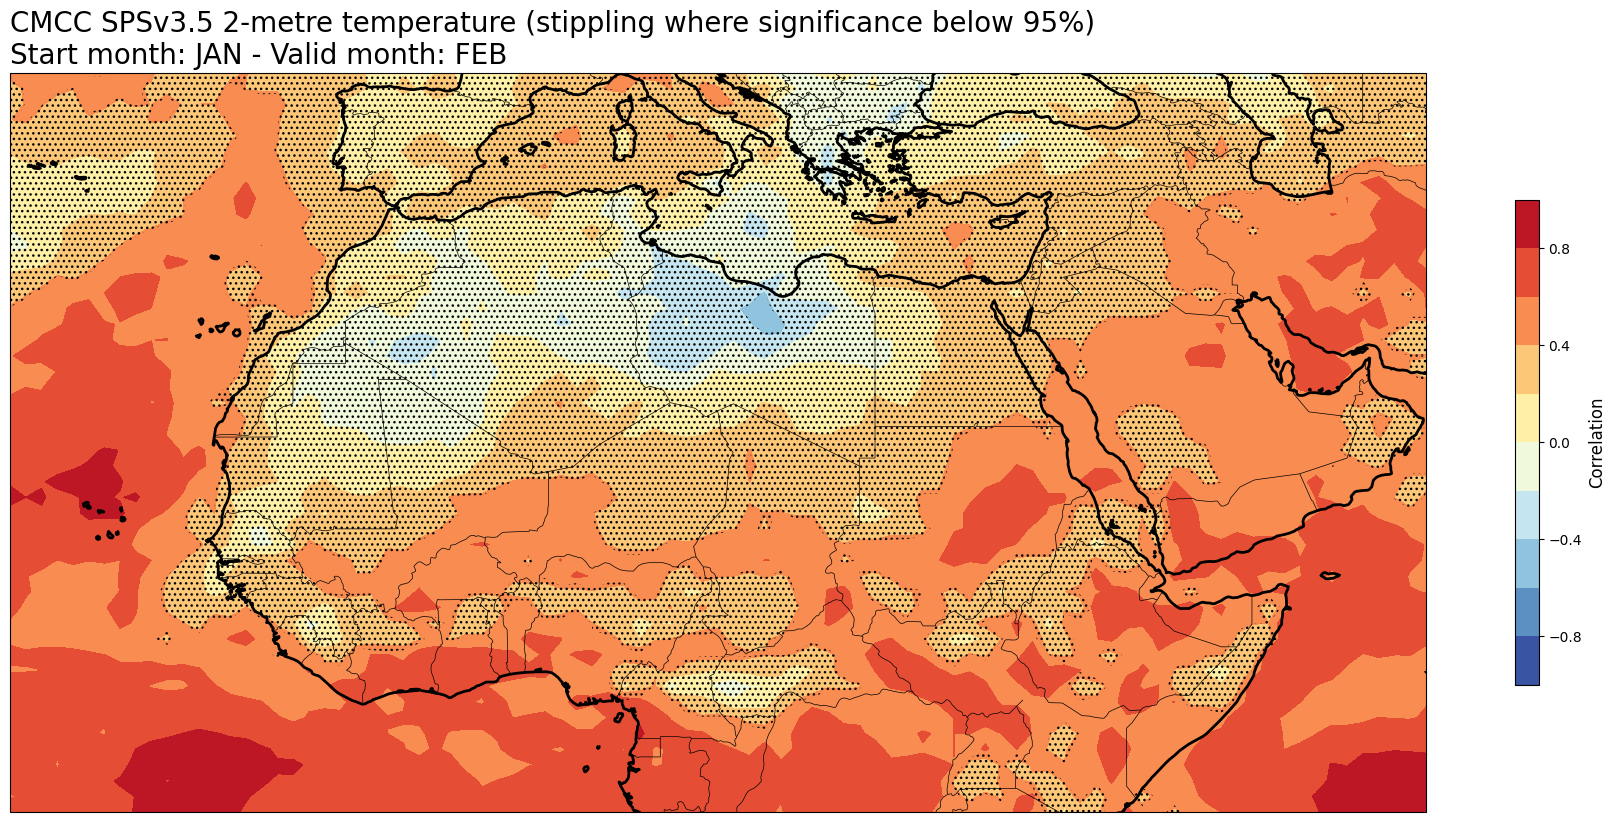

In [24]:
# Read the data files
corr = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr.nc')
corr_pval = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr_pval.nc')
# RE-ARRANGE the DATASETS longitude values for plotting purposes
corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')
corr_pval = corr_pval.assign_coords(lon=(((corr_pval.lon + 180) % 360) - 180)).sortby('lon')


thiscorr = corr.sel(forecastMonth=fcmonth)
thiscorrpval = corr_pval.sel(forecastMonth=fcmonth)

for var in thiscorr.data_vars:
    fig = plt.figure(figsize=(18,10))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    corrvalues = thiscorr[var].values
    corrpvalvalues = thiscorrpval[var].values

    if corrvalues.T.shape == (thiscorr[var].lat.size, thiscorr[var].lon.size):
        print('Data values matrices need to be transposed')
        corrvalues = corrvalues.T
        corrpvalvalues = corrpvalvalues.T
    elif corrvalues.shape == (thiscorr[var].lat.size, thiscorr[var].lon.size):
        pass
        # print('Data values matrices shapes are ok')
    else:
        raise BaseException(f'Unexpected data value matrix shape: {corrvalues.shape}' )


    plt.contourf(thiscorr[var].lon,thiscorr[var].lat,corrvalues,levels=np.linspace(-1.,1.,11),cmap='RdYlBu_r')
    cb = plt.colorbar(shrink=0.5)
    cb.ax.set_ylabel('Correlation',fontsize=12)
    origylim = ax.get_ylim()
    plt.contourf(thiscorrpval[var].lon,thiscorrpval[var].lat,corrpvalvalues,levels=[0.05,np.inf],hatches=['...',None],colors='none')
    # We need to ensure after running plt.contourf() the ylim hasn't changed
    if ax.get_ylim()!=origylim:
        ax.set_ylim(origylim)

    plt.title(tit_line1 + f' {VARNAMES[var]}' +' (stippling where significance below 95%)\n' + tit_line2,loc='left')


    plt.tight_layout()
    figname = f'{DATADIR}/plots/stmonth{config["start_month"]:02d}/{hcst_bname}.{aggr}.fcmonth{fcmonth}.{var}.corr.png'
    plt.savefig(figname)

In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import calendar
import ipywidgets as widgets

# Initial setup
hcst_bname="ecmwf_51_1993-2016_monthly_mean"
# config = {'start_month': 1}  # Modify as needed for your context
VARNAMES = {'t2m': '2-metre temperature'}
origin_labels = {'institution': 'CMCC', 'name': 'SPSv3.5'}
tit_line1 = '{institution} {name}'.format(**origin_labels)

# Load the datasets
def load_data(aggr):
    corr = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr.nc')
    corr_pval = xr.open_dataset(f'{DATADIR}/scores/{hcst_bname}.{aggr}.corr_pval.nc')
    # Re-arrange longitude values for plotting purposes
    corr = corr.assign_coords(lon=(((corr.lon + 180) % 360) - 180)).sortby('lon')
    corr_pval = corr_pval.assign_coords(lon=(((corr_pval.lon + 180) % 360) - 180)).sortby('lon')
    return corr, corr_pval

# Define the plot function
def plot_corr(aggr, fcmonth):
    corr, corr_pval = load_data(aggr)

    # Prepare title line 2 based on aggregation
    tit_line2_base = f'Start month: {calendar.month_abbr[config["start_month"]].upper()}'
    if aggr == '1m':
        validmonth = config['start_month'] + (fcmonth - 1)
        validmonth = validmonth if validmonth <= 12 else validmonth - 12
        tit_line2 = tit_line2_base + f' - Valid month: {calendar.month_abbr[validmonth].upper()}'
    elif aggr == '3m':
        validmonths = [calendar.month_abbr[(config['start_month'] + (fcmonth - 1) - shift) % 12] for shift in range(3)]
        tit_line2 = tit_line2_base + f' - Valid months: {" ".join(reversed(validmonths))}'
    else:
        raise ValueError(f'Unexpected aggregation {aggr}')

    # Select data for the chosen forecast month
    thiscorr = corr.sel(forecastMonth=fcmonth)
    thiscorrpval = corr_pval.sel(forecastMonth=fcmonth)

    # Plot each variable in the dataset
    for var in thiscorr.data_vars:
        fig = plt.figure(figsize=(18, 10))
        ax = plt.axes(projection=ccrs.PlateCarree())
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.0)
        corrvalues = thiscorr[var].values
        corrpvalvalues = thiscorrpval[var].values

        if corrvalues.T.shape == (thiscorr[var].lat.size, thiscorr[var].lon.size):
            corrvalues = corrvalues.T
            corrpvalvalues = corrpvalvalues.T

        plt.contourf(thiscorr[var].lon, thiscorr[var].lat, corrvalues, levels=np.linspace(-1., 1., 11), cmap='RdYlBu_r')
        cb = plt.colorbar(shrink=0.5)
        cb.ax.set_ylabel('Correlation', fontsize=12)
        origylim = ax.get_ylim()
        plt.contourf(thiscorrpval[var].lon, thiscorrpval[var].lat, corrpvalvalues, levels=[0.05, np.inf], hatches=['...', None], colors='none')
        if ax.get_ylim() != origylim:
            ax.set_ylim(origylim)

        plt.title(f"{tit_line1} {VARNAMES[var]} (stippling where significance below 95%)\n{tit_line2}", loc='left')
        plt.tight_layout()
        plt.show()

# Create interactive widgets for `aggr` and `fcmonth`
aggr_dropdown = widgets.Dropdown(options=['1m', '3m'], value='1m', description='Aggregation:')
fcmonth_slider = widgets.IntSlider(value=3, min=2, max=4, step=1, description='Forecast Month:')

# Display the interactive plot with a single call
widgets.interactive(plot_corr, aggr=aggr_dropdown, fcmonth=fcmonth_slider)


interactive(children=(Dropdown(description='Aggregation:', options=('1m', '3m'), value='1m'), IntSlider(value=…

In [13]:
import os
print(os.listdir('/content/drive/MyDrive/MODELIZATION/MODELISATION/DATA/scores/'))


['cmcc_s35_stmonth03_hindcast1993-2016_monthly.1m.corr.nc', 'cmcc_s35_stmonth03_hindcast1993-2016_monthly.1m.corr_pval.nc', 'cmcc_s35_stmonth03_hindcast1993-2016_monthly.3m.corr.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.corr.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.corr.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.corr_pval.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.corr_pval.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.rps.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.bs.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.roc.nc', 'ecmwf_51_1993-2016_monthly_mean.1m.rocss.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.rps.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.bs.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.roc.nc', 'ecmwf_51_1993-2016_monthly_mean.3m.rocss.nc']
